# Calculate Codon Usage for Specific Gene(GFP/LacZ)

In [ ]:
import pandas as pd
from collections import defaultdict
import sys

# 1. Defining Standard Genetic Code Table
CODON_TABLE = {
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
    'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
    'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
    'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
    'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
    'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
    'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
    'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
    'TAC':'Y', 'TAT':'Y', 'TGC':'C', 'TGT':'C',
    'TGG':'W',
    # Terminal Codon
    'TAA':'*', 'TAG':'*', 'TGA':'*' 
}

# AA -> Codons
AA_TO_CODONS = defaultdict(list)
for codon, aa in CODON_TABLE.items():
    if aa != '*': # Exclude terminal codons
        AA_TO_CODONS[aa].append(codon)

def calculate_top_codon_usage(input_file, output_file, top_k=2000):
    print(f"Loading: {input_file} ...")
    
    df = pd.read_csv(input_file)
    df['te_pred'] = pd.to_numeric(df['te_pred'], errors='coerce')
    df = df.dropna(subset=['te_pred'])

    # -----------------------------------------------------------
    # Sort and grab top-K
    # -----------------------------------------------------------
    print(f"Descend sorting by te_pred and extract {top_k} Sequences.")
    df_sorted = df.sort_values(by='te_pred', ascending=False)
    df_top = df_sorted.head(top_k)
    
    print(f"{len(df_top)} sequences extracted for analysis.")
    if len(df_top) < top_k:
        print(f"Total length ({len(df)}) < top-k ({top_k})。")

    counts = defaultdict(lambda: defaultdict(int))
    for cds in df_top['cds_sequence']:
        if not isinstance(cds, str): continue
        cds = cds.strip().upper()

        if len(cds) % 3 != 0:
            continue
        
        for i in range(0, len(cds), 3):
            codon = cds[i:i+3]
            if codon in CODON_TABLE:
                aa = CODON_TABLE[codon]
                if aa != '*':
                    counts[aa][codon] += 1

    print(f"Results written to: {output_file} ...")
    with open(output_file, 'w', encoding='utf-8') as out:
        sorted_aas = sorted(AA_TO_CODONS.keys())
        
        for aa in sorted_aas:
            synonymous_codons = sorted(AA_TO_CODONS[aa])
            total_count = sum(counts[aa][c] for c in synonymous_codons)
            
            if total_count > 0:
                freqs = []
                for codon in synonymous_codons:
                    count = counts[aa][codon]
                    freq = count / total_count
                    freqs.append(freq)
                
                out.write(f"{aa}\n")
                out.write(" ".join(synonymous_codons) + "\n")
                freq_str = " ".join([f"{f:.6f}" for f in freqs])
                out.write(freq_str + "\n")
                out.write("\n")

    print("Analysis Completed")

if __name__ == "__main__":
    calculate_top_codon_usage('GFP/High_TE_Seq_GFP.csv', 'GFP/GFP_codon_usage_by_aa_top100.txt', top_k=100)
    # calculate_top_codon_usage('LacZ/High_TE_Seq_LacZ.csv', 'LacZ/LacZ_codon_usage_by_aa_top100.txt', top_k=100)

Loading: GFP/High_TE_Seq_GFP.csv ...
Descend sorting by te_pred and extract 100 Sequences.
100 sequences extracted for analysis.
Results written to: GFP/GFP_codon_usage_by_aa_top100.txt ...
Analysis Completed


# Calculate Codon Bias Correlation

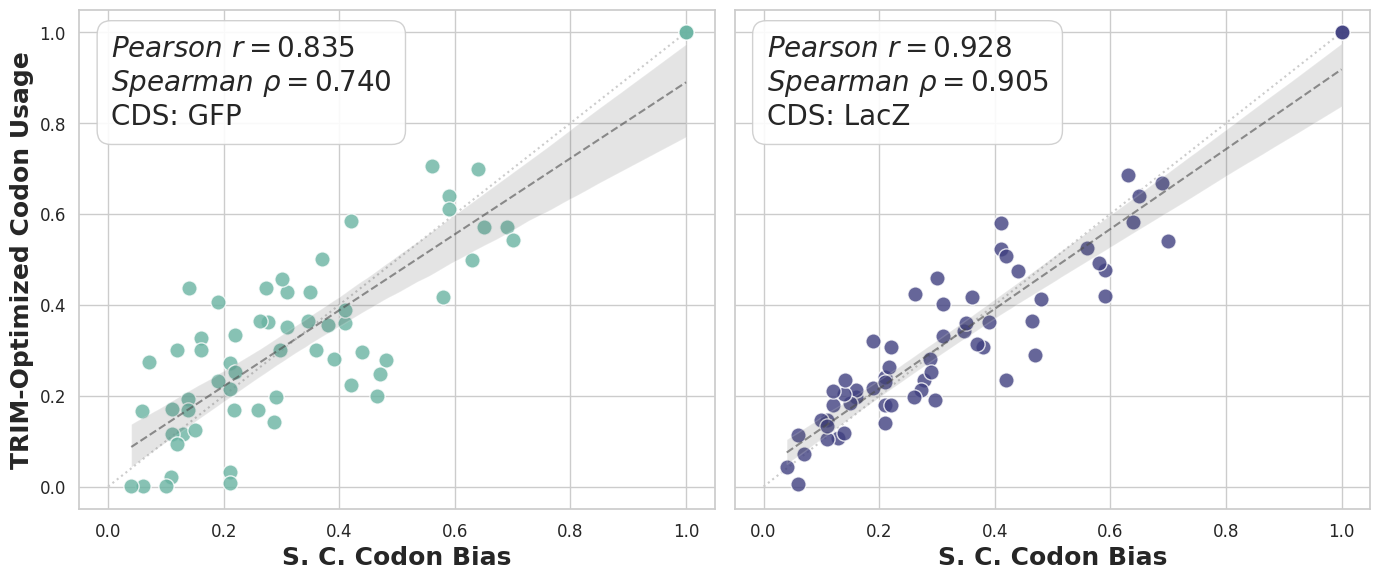

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# =============================================================================
# 1. Standard S. cerevisiae Codon Bias
# =============================================================================
CODON_PROBS_REAL = {
    "TTT": 0.59,"TTC": 0.41,"TTA": 0.28,"TTG": 0.29,
    "CTT": 0.13,"CTC": 0.06,"CTA": 0.14,"CTG": 0.11,
    "ATT": 0.46,"ATC": 0.26,"ATA": 0.27,"ATG": 1.00,
    "GTT": 0.39,"GTC": 0.21,"GTA": 0.21,"GTG": 0.19,
    "TCT": 0.26,"TCC": 0.16,"TCA": 0.21,"TCG": 0.10,
    "AGT": 0.16,"AGC": 0.11,"CCT": 0.31,"CCC": 0.15,
    "CCA": 0.42,"CCG": 0.12,"ACT": 0.35,"ACC": 0.22,
    "ACA": 0.30,"ACG": 0.14,"GCT": 0.38,"GCC": 0.22,
    "GCA": 0.29,"GCG": 0.11,"TAT": 0.56,"TAC": 0.44,
    "TAA": 0.47,"TAG": 0.23,"TGA": 0.30,"CAT": 0.64,
    "CAC": 0.36,"CAA": 0.69,"CAG": 0.31,"AAT": 0.59,
    "AAC": 0.41,"AAA": 0.58,"AAG": 0.42,"GAT": 0.65,
    "GAC": 0.35,"GAA": 0.70,"GAG": 0.30,"TGT": 0.63,
    "TGC": 0.37,"TGG": 1.00,"CGT": 0.14,"CGC": 0.06,
    "CGA": 0.07,"CGG": 0.04,"AGA": 0.48,"AGG": 0.21,
    "GGT": 0.47,"GGC": 0.19,"GGA": 0.22,"GGG": 0.12,
}

GFP_RAW_DATA = """
A
GCA GCC GCG GCT
0.196056 0.332833 0.115167 0.355944

C
TGC TGT
0.500250 0.499750

D
GAC GAT
0.429000 0.571000

E
GAA GAG
0.543281 0.456719

F
TTC TTT
0.360545 0.639455

G
GGA GGC GGG GGT
0.252391 0.407326 0.092696 0.247587

H
CAC CAT
0.300050 0.699950

I
ATA ATC ATT
0.436227 0.364864 0.198909

K
AAA AAG
0.416450 0.583550

L
CTA CTC CTG CTT TTA TTG
0.193650 0.167100 0.020475 0.115000 0.362475 0.141300

M
ATG
1.000000

N
AAC AAT
0.388000 0.612000

P
CCA CCC CCG CCT
0.223900 0.123800 0.301350 0.350950

Q
CAA CAG
0.572071 0.427929

R
AGA AGG CGA CGC CGG CGT
0.279500 0.008714 0.274429 0.000500 0.000571 0.436286

S
AGC AGT TCA TCC TCG TCT
0.170200 0.300100 0.031100 0.327800 0.001950 0.168850

T
ACA ACC ACG ACT
0.299556 0.167639 0.167722 0.365083

V
GTA GTC GTG GTT
0.214094 0.272219 0.232156 0.281531

W
TGG
1.000000

Y
TAC TAT
0.295182 0.704818
"""

LACZ_RAW_DATA = """
A
GCA GCC GCG GCT
0.251981 0.306110 0.133851 0.308058

C
TGC TGT
0.314750 0.685250

D
GAC GAT
0.359555 0.640445

E
GAA GAG
0.540852 0.459148

F
TTC TTT
0.523895 0.476105

G
GGA GGC GGG GGT
0.179254 0.321204 0.209472 0.290070

H
CAC CAT
0.416667 0.583333

I
ATA ATC ATT
0.212449 0.423000 0.364551

K
AAA AAG
0.491881 0.508119

L
CTA CTC CTG CTT TTA TTG
0.116786 0.113917 0.145797 0.106641 0.235536 0.281323

M
ATG
1.000000

N
AAC AAT
0.580298 0.419702

P
CCA CCC CCG CCT
0.234315 0.184395 0.178548 0.402742

Q
CAA CAG
0.669224 0.330776

R
AGA AGG CGA CGC CGG CGT
0.413311 0.230258 0.072652 0.006212 0.042894 0.234674

S
AGC AGT TCA TCC TCG TCT
0.105292 0.212267 0.140733 0.197917 0.147500 0.196292

T
ACA ACC ACG ACT
0.191286 0.262813 0.202652 0.343250

V
GTA GTC GTG GTT
0.179523 0.241828 0.217102 0.361547

W
TGG
1.000000

Y
TAC TAT
0.475234 0.524766
"""


# =============================================================================
# 3. Dataprocessing and analyzing
# =============================================================================
def parse_custom_format(text_data):
    data = {}
    lines = text_data.strip().split("\n")
    current_codons = []

    for line in lines:
        line = line.strip()
        if not line:
            continue

        parts = line.split()

        if parts[0].isalpha() and len(parts[0]) == 3 and len(parts[0]) < 4:
            if len(parts[0]) == 1:
                continue
            current_codons = parts

        elif parts[0].replace(".", "", 1).isdigit():
            if len(parts) == len(current_codons):
                for codon, freq in zip(current_codons, parts):
                    data[codon] = float(freq)
            else:
                print(f"[Warning] Unmatched numbers: {current_codons} vs {parts}")

    return data


def get_normalized_real_bias(real_probs_dict):
    """
    Normalize real codon usage frequency.
    """
    # Codon -> AA
    genetic_code = {
        "ATA": "I","ATC": "I","ATT": "I","ATG": "M",
        "ACA": "T","ACC": "T","ACG": "T","ACT": "T",
        "AAC": "N","AAT": "N","AAA": "K","AAG": "K",
        "AGC": "S","AGT": "S","AGA": "R","AGG": "R",
        "CTA": "L","CTC": "L","CTG": "L","CTT": "L",
        "CCA": "P","CCC": "P","CCG": "P","CCT": "P",
        "CAC": "H","CAT": "H","CAA": "Q","CAG": "Q",
        "CGA": "R","CGC": "R","CGG": "R","CGT": "R",
        "GTA": "V","GTC": "V","GTG": "V","GTT": "V",
        "GCA": "A","GCC": "A","GCG": "A","GCT": "A",
        "GAC": "D","GAT": "D","GAA": "E","GAG": "E",
        "GGA": "G","GGC": "G","GGG": "G","GGT": "G",
        "TCA": "S","TCC": "S","TCG": "S","TCT": "S",
        "TTC": "F","TTT": "F","TTA": "L","TTG": "L",
        "TAC": "Y","TAT": "Y","TGC": "C","TGT": "C",
        "TGG": "W",
    }

    aa_sums = {}
    for codon, prob in real_probs_dict.items():
        if codon in genetic_code:
            aa = genetic_code[codon]
            aa_sums[aa] = aa_sums.get(aa, 0) + prob

    normalized_dict = {}
    for codon, prob in real_probs_dict.items():
        if codon in genetic_code:
            aa = genetic_code[codon]
            if aa_sums[aa] > 0:
                normalized_dict[codon] = prob / aa_sums[aa]
            else:
                normalized_dict[codon] = 0
    return normalized_dict


# =============================================================================
# 4. PLOT
# =============================================================================

gfp_dict = parse_custom_format(GFP_RAW_DATA)
lacz_dict = parse_custom_format(LACZ_RAW_DATA)
real_dict_norm = get_normalized_real_bias(CODON_PROBS_REAL)

rows = []
stop_codons = ["TAA", "TAG", "TGA"]

for codon, real_freq in real_dict_norm.items():
    if codon in stop_codons:
        continue  # Exclude Terminal Codons

    if codon in gfp_dict and codon in lacz_dict:
        rows.append(
            {
                "Codon": codon,
                "Real_Freq": real_freq,
                "GFP_Freq": gfp_dict[codon],
                "LacZ_Freq": lacz_dict[codon],
            }
        )

df = pd.DataFrame(rows)

sns.set(style="whitegrid", font_scale=1.1)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)


def plot_correlation(ax, x_col, y_col, title, color_code):
    if df.empty:
        ax.text(
            0.5,
            0.5,
            "No Data Parsed\nPlease paste full data in script",
            ha="center",
            va="center",
            transform=ax.transAxes,
        )
        return

    sns.scatterplot(
        data=df,
        x=x_col,
        y=y_col,
        ax=ax,
        color=color_code,
        s=120,
        alpha=0.8,
        edgecolor="white",
        linewidth=1,
    )

    sns.regplot(
        data=df,
        x=x_col,
        y=y_col,
        ax=ax,
        scatter=False,
        color=".3",
        line_kws={"linestyle": "--", "alpha": 0.6, "linewidth": 1.5},
    )

    r, p_r = pearsonr(df[x_col], df[y_col])
    rho, p_rho = spearmanr(df[x_col], df[y_col])

    text_str = f"$Pearson\ r = {r:.3f}$\n$Spearman\ \\rho = {rho:.3f}$\nCDS: {title}"
    ax.text(
        0.05,
        0.95,
        text_str,
        transform=ax.transAxes,
        fontsize=20,
        verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="#cccccc", alpha=0.9),
    )
    ax.set_xlabel("S. C. Codon Bias", fontweight="bold", fontsize=18)
    ax.set_ylabel("TRIM-Optimized Codon Usage", fontweight="bold", fontsize=18)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.plot([0, 1], [0, 1], ls=":", c=".8", zorder=0)


# GFP Plot
plot_correlation(axes[0], "Real_Freq", "GFP_Freq", "GFP", "#69b3a2")  # 蓝绿色

# LacZ Plot
plot_correlation(axes[1], "Real_Freq", "LacZ_Freq", "LacZ", "#404080")  # 蓝紫色

plt.tight_layout()
plt.show()
# plt.savefig("codon_bias_correlation.png", dpi=300) # savefig图片

# Calculate Codon Usage by 100-2000 Top TE Sequences of GFP/LacZ

In [ ]:
import os
import numpy as np
from scipy.stats import pearsonr, spearmanr
from collections import defaultdict

# ==========================================
# 1. Preparation and normalization
# ==========================================
CODON_PROBS_REAL = {
    "TTT": 0.59,"TTC": 0.41,"TTA": 0.28,
    "TTG": 0.29,"CTT": 0.13,"CTC": 0.06,
    "CTA": 0.14,"CTG": 0.11,"ATT": 0.46,
    "ATC": 0.26,"ATA": 0.27,"ATG": 1.00,
    "GTT": 0.39,"GTC": 0.21,"GTA": 0.21,
    "GTG": 0.19,"TCT": 0.26,"TCC": 0.16,
    "TCA": 0.21,"TCG": 0.10,"AGT": 0.16,
    "AGC": 0.11,"CCT": 0.31,"CCC": 0.15,
    "CCA": 0.42,"CCG": 0.12,"ACT": 0.35,
    "ACC": 0.22,"ACA": 0.30,"ACG": 0.14,
    "GCT": 0.38,"GCC": 0.22,"GCA": 0.29,
    "GCG": 0.11,"TAT": 0.56,"TAC": 0.44,
    "TAA": 0.47,"TAG": 0.23,"TGA": 0.30,
    "CAT": 0.64,"CAC": 0.36,"CAA": 0.69,
    "CAG": 0.31,"AAT": 0.59,"AAC": 0.41,
    "AAA": 0.58,"AAG": 0.42,"GAT": 0.65,
    "GAC": 0.35,"GAA": 0.70,"GAG": 0.30,
    "TGT": 0.63,"TGC": 0.37,"TGG": 1.00,
    "CGT": 0.14,"CGC": 0.06,"CGA": 0.07,
    "CGG": 0.04,"AGA": 0.48,"AGG": 0.21,
    "GGT": 0.47,"GGC": 0.19,"GGA": 0.22,
    "GGG": 0.12,
}

CODON_TABLE = {
    "ATA": "I","ATC": "I","ATT": "I",
    "ATG": "M","ACA": "T","ACC": "T",
    "ACG": "T","ACT": "T","AAC": "N",
    "AAT": "N","AAA": "K","AAG": "K",
    "AGC": "S","AGT": "S","AGA": "R",
    "AGG": "R","CTA": "L","CTC": "L",
    "CTG": "L","CTT": "L","CCA": "P",
    "CCC": "P","CCG": "P","CCT": "P",
    "CAC": "H","CAT": "H","CAA": "Q",
    "CAG": "Q","CGA": "R","CGC": "R",
    "CGG": "R","CGT": "R","GTA": "V",
    "GTC": "V","GTG": "V","GTT": "V",
    "GCA": "A","GCC": "A","GCG": "A",
    "GCT": "A","GAC": "D","GAT": "D",
    "GAA": "E","GAG": "E","GGA": "G",
    "GGC": "G","GGG": "G","GGT": "G",
    "TCA": "S","TCC": "S","TCG": "S",
    "TCT": "S","TTC": "F","TTT": "F",
    "TTA": "L","TTG": "L","TAC": "Y",
    "TAT": "Y","TGC": "C","TGT": "C",
    "TGG": "W",
}


def get_normalized_real_bias(raw_probs):
    """
    Normalize RAW codon bias and usage
    """
    aa_sums = defaultdict(float)
    for codon, val in raw_probs.items():
        if codon in CODON_TABLE:  # exclude terminal codon
            aa = CODON_TABLE[codon]
            aa_sums[aa] += val

    norm_probs = {}
    for codon, val in raw_probs.items():
        if codon in CODON_TABLE:
            aa = CODON_TABLE[codon]
            if aa_sums[aa] > 0:
                norm_probs[codon] = val / aa_sums[aa]
            else:
                norm_probs[codon] = 0.0
    return norm_probs


REAL_BIAS_NORM = get_normalized_real_bias(CODON_PROBS_REAL)


# ==========================================
# 2. Load file and calculate relativity
# ==========================================


def parse_usage_file(filepath):
    """
    Parse file to form a usage dict
    """
    data = {}
    if not os.path.exists(filepath):
        return None

    with open(filepath, "r", encoding="utf-8") as f:
        lines = [l.strip() for l in f if l.strip()]

    i = 0
    while i < len(lines):
        line = lines[i]
        if len(line) == 1 and line.isalpha():
            if i + 2 < len(lines):
                codons = lines[i + 1].split()
                freqs = lines[i + 2].split()

                if len(codons) == len(freqs):
                    for c, freq in zip(codons, freqs):
                        data[c] = float(freq)
                i += 3
            else:
                break
        else:
            i += 1
    return data


def calc_metrics(file_probs, real_probs):
    x = []  # File
    y = []  # Real

    for codon, real_val in real_probs.items():
        if codon in file_probs:
            x.append(file_probs[codon])
            y.append(real_val)
        else:
            x.append(0.0)
            y.append(real_val)

    if len(x) < 2:
        return 0.0, 0.0

    pearson_r, _ = pearsonr(x, y)
    spearman_rho, _ = spearmanr(x, y)

    return pearson_r, spearman_rho


def main():
    genes = ["GFP", "LacZ"]
    top_n_values = [100, 500, 1000, 1500, 2000]
    results = defaultdict(dict)

    for gene in genes:
        for n in top_n_values:
            filename = f"{gene}_codon_usage_by_aa_top{n}.txt"

            # Parsing files
            file_data = parse_usage_file(filename)

            if file_data is None:
                print(f"Warning: File {filename} not found. Skipping.")
                results[n][gene] = (0.0, 0.0)
                continue

            # Calculating Coefficiency
            r, rho = calc_metrics(file_data, REAL_BIAS_NORM)
            results[n][gene] = (r, rho)

            print(f"Processed {filename}: Pearson={r:.3f}, Spearman={rho:.3f}")


if __name__ == "__main__":
    main()

# Calculating Mean MFE Heatmap and Structural Deviation

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import multiprocessing
from functools import partial
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter

# Import ViennaRNA
try:
    import RNA
except ImportError:
    class MockRNA:
        def md(self): return self
        def fold_compound(self, s, md): return self
        def mfe(self): return (None, 0.0)
        def exp_params_rescale(self, mfe): pass
        def pf(self): pass
        def plist_from_probs(self, cutoff): return []
        def fold(self, s): return ("...", -5.0) 
    RNA = MockRNA()

PLOT_START = -50   
PLOT_END   = 717   
WINDOW_SIZE = 15   

PLOT_TOP_K = 128 
CPU_CORES  = 112   

TEMP_C = 30.0
CUTOFF = 1e-5
CSV_FILE_PATH = "GFP/High_TE_Seq.csv"
OUTPUT_IMAGE_NAME = "structure_eccentricity.png"

CODON_PROBS = {"TTT": 0.59, "TTC": 0.41, "TTA": 0.28, "TTG": 0.29, "CTT": 0.13, "CTC": 0.06, "CTA": 0.14, "CTG": 0.11, "ATT": 0.46, "ATC": 0.26, "ATA": 0.27, "ATG": 1.00, "GTT": 0.39, "GTC": 0.21, "GTA": 0.21, "GTG": 0.19, "TCT": 0.26, "TCC": 0.16, "TCA": 0.21, "TCG": 0.10, "AGT": 0.16, "AGC": 0.11, "CCT": 0.31, "CCC": 0.15, "CCA": 0.42, "CCG": 0.12, "ACT": 0.35, "ACC": 0.22, "ACA": 0.30, "ACG": 0.14, "GCT": 0.38, "GCC": 0.22, "GCA": 0.29, "GCG": 0.11, "TAT": 0.56, "TAC": 0.44, "TAA": 0.47, "TAG": 0.23, "TGA": 0.30, "CAT": 0.64, "CAC": 0.36, "CAA": 0.69, "CAG": 0.31, "AAT": 0.59, "AAC": 0.41, "AAA": 0.58, "AAG": 0.42, "GAT": 0.65, "GAC": 0.35, "GAA": 0.70, "GAG": 0.30, "TGT": 0.63, "TGC": 0.37, "TGG": 1.00, "CGT": 0.14, "CGC": 0.06, "CGA": 0.07, "CGG": 0.04, "AGA": 0.48, "AGG": 0.21, "GGT": 0.47, "GGC": 0.19, "GGA": 0.22, "GGG": 0.12}
AA_TO_CODONS = {"A": ["GCT","GCC","GCA","GCG"], "R": ["CGT","CGC","CGA","CGG","AGA","AGG"], "N": ["AAT","AAC"], "D": ["GAT","GAC"], "C": ["TGT","TGC"], "Q": ["CAA","CAG"], "E": ["GAA","GAG"], "G": ["GGT","GGC","GGA","GGG"], "H": ["CAT","CAC"], "I": ["ATT","ATC","ATA"], "L": ["TTA","TTG","CTT","CTC","CTA","CTG"], "K": ["AAA","AAG"], "M": ["ATG"], "F": ["TTT","TTC"], "P": ["CCT","CCC","CCA","CCG"], "S": ["TCT","TCC","TCA","TCG","AGT","AGC"], "T": ["ACT","ACC","ACA","ACG"], "W": ["TGG"], "Y": ["TAT","TAC"], "V": ["GTT","GTC","GTA","GTG"], "*": ["TAA","TAG","TGA"]}


def calculate_window_mfe(full_sequence, center_indices, radius=15):
    mfes = []
    seq_len = len(full_sequence)
    for center in center_indices:
        start = center - radius
        end = center + radius + 1
        if start < 0 or end > seq_len:
            mfes.append(np.nan)
        else:
            sub_seq = full_sequence[start:end].replace('T', 'U')
            if len(sub_seq) == 0:
                mfes.append(np.nan)
            else:
                _, mfe_val = RNA.fold(sub_seq)
                mfes.append(mfe_val)
    return np.array(mfes)

def calculate_pairing_probs_internal(seq_str):
    s = str(seq_str).replace('T', 'U')
    n = len(s)
    p_paired = np.zeros(n, dtype=np.float32)
    if n > 0:
        md = RNA.md()
        md.temperature = float(TEMP_C)
        fc = RNA.fold_compound(s, md)
        _, mfe = fc.mfe()
        fc.exp_params_rescale(mfe)
        fc.pf()
        plist = fc.plist_from_probs(float(CUTOFF))
        for e in plist:
            try: i0, j0, p = e.i - 1, e.j - 1, e.p
            except AttributeError: i0, j0, p = e[0]-1, e[1]-1, e[2]
            if 0 <= i0 < n: p_paired[i0] += p
            if 0 <= j0 < n: p_paired[j0] += p
    return p_paired

def worker_process_all(row_tuple, best_map, p_start, p_end, w_radius):
    idx, row = row_tuple
    utr5, cds, utr3 = str(row['utr5_sequence']), str(row['cds_sequence']), str(row['utr3_sequence'])
    full_seq = utr5 + cds + utr3
    
    # 1. Calculate Pairing probability
    probs = calculate_pairing_probs_internal(full_seq)
    
    abs_start = len(utr5) + p_start
    abs_end = len(utr5) + p_end
    window_len = p_end - p_start
    
    prob_slice = np.zeros(window_len, dtype=np.float32)
    valid_start = max(0, abs_start)
    valid_end = min(len(probs), abs_end)
    
    if valid_start < valid_end:
        prob_slice[valid_start-abs_start : valid_start-abs_start+(valid_end-valid_start)] = probs[valid_start:valid_end]

    # 2. Calculate MFE in Sliding Window
    center_indices = np.arange(abs_start, abs_end)
    mfe_slice = calculate_window_mfe(full_seq, center_indices, radius=w_radius)

    # 3. Record Non-preferred Codon Position
    non_optimal_indices = []
    cds_start_idx = len(utr5)
    limit = (len(cds) // 3) * 3
    for i in range(0, limit, 3):
        codon = cds[i:i+3]
        aa = next((a for a, c_list in AA_TO_CODONS.items() if codon in c_list), None)
        if aa and codon != best_map.get(aa):
            for pos_rel in [i, i+1, i+2]:
                if p_start <= pos_rel < p_end:
                    plot_idx = pos_rel - p_start
                    non_optimal_indices.append(plot_idx)

    return {"prob_slice": prob_slice, "mfe_slice": mfe_slice, "non_opt_indices": non_optimal_indices}


def biological_axis_formatter(x, pos):
    """
    ATG 'A' -> POS +1
    UTR end -> POS -1
    """
    val = int(x)
    if val >= 0:
        return f"{val + 1}"
    else:
        return f"{val}"


def main():
    best_codon_map = {aa: max(codons, key=lambda c: CODON_PROBS.get(c, 0)) for aa, codons in AA_TO_CODONS.items()}
    
    try:
        df = pd.read_csv(CSV_FILE_PATH).sort_values(by='te_pred', ascending=False).head(PLOT_TOP_K)
        print(f"Reading data... Analyzing Top {PLOT_TOP_K} sequences.")
    except Exception as e:
        print(f"Error reading file: {e}"); return

    print(f"Parallel processing with {CPU_CORES} cores...")
    with multiprocessing.Pool(processes=CPU_CORES) as pool:
        func = partial(worker_process_all, best_map=best_codon_map, 
                       p_start=PLOT_START, p_end=PLOT_END, w_radius=WINDOW_SIZE)
        results = pool.map(func, list(df.iterrows()))

    prob_matrix = np.array([res['prob_slice'] for res in results])
    mfe_matrix = np.array([res['mfe_slice'] for res in results])
    mean_probs = np.nanmean(prob_matrix, axis=0)
    
    seq_len = mean_probs.shape[0]
    ecc_numerator = np.zeros(seq_len)   
    ecc_denominator = np.zeros(seq_len) 
    
    for i, res in enumerate(results):
        indices = res['non_opt_indices']
        if not indices:
            continue
        current_seq_probs = prob_matrix[i]
        for idx in indices:
            if idx < seq_len:
                deviation = abs(current_seq_probs[idx] - mean_probs[idx])
                ecc_numerator[idx] += deviation
                ecc_denominator[idx] += 1
    
    eccentricity = np.divide(ecc_numerator, ecc_denominator, 
                             out=np.zeros_like(ecc_numerator), 
                             where=ecc_denominator!=0)
    mean_mfe = np.nanmean(mfe_matrix, axis=0)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), sharex=True, 
                                   gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.1})
    plt.style.use('seaborn-v0_8-white')

    # --- Mean MFE Heatmap ---
    mfe_data = mean_mfe.reshape(1, -1)
    im1 = ax1.imshow(mfe_data, aspect='auto', cmap='RdYlBu_r', 
                     extent=[PLOT_START, PLOT_END, 0, 1], vmin=-10, vmax=0)
    
    ax1.set_yticks([]) 
    ax1.set_ylabel('Mean MFE', fontsize=24, fontweight='bold', labelpad=20)
    # Plot division between -1 and 1
    ax1.axvline(x=0, color='white', linestyle='--', alpha=0.8, linewidth=1.5)
    
    # --- Structural Deviation Heatmap ---
    ecc_data = eccentricity.reshape(1, -1)
    im2 = ax2.imshow(ecc_data, aspect='auto', cmap='magma_r', 
                     extent=[PLOT_START, PLOT_END, 0, 1], vmin=0, vmax=np.max(eccentricity)*0.8)
    ax2.set_yticks([])
    ax2.set_ylabel('Struct Deviation', fontsize=24, fontweight='bold', labelpad=20)
    ax2.set_xlabel('Position relative to Start Codon (A of ATG = +1)', fontsize=24, fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5, linewidth=1.5)
    formatter = FuncFormatter(biological_axis_formatter)
    ax2.xaxis.set_major_formatter(formatter)
    ax2.tick_params(axis='x', labelsize=20)

    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

    # -----------------------------------------------------------
    plt.subplots_adjust(left=0.08, right=0.88, top=0.92, bottom=0.1)
    pos1 = ax1.get_position()
    pos2 = ax2.get_position()

    # Colorbar 1
    cbar_ax1 = fig.add_axes([0.89, pos1.y0, 0.015, pos1.height])
    cbar1 = plt.colorbar(im1, cax=cbar_ax1)
    cbar1.set_label('Mean MFE (kcal/mol)', fontsize=20)
    cbar1.ax.tick_params(labelsize=16)

    # Colorbar 2
    cbar_ax2 = fig.add_axes([0.89, pos2.y0, 0.015, pos2.height])
    cbar2 = plt.colorbar(im2, cax=cbar_ax2)
    cbar2.set_label('Weighted Deviation', fontsize=20)
    cbar2.ax.tick_params(labelsize=16)
    # -----------------------------------------------------------

    plt.savefig(OUTPUT_IMAGE_NAME, dpi=450, bbox_inches='tight')
    print(f"Analysis Complete. Saved to: {OUTPUT_IMAGE_NAME}")

if __name__ == "__main__":
    multiprocessing.freeze_support()
    main()